# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import json 
import ipympl
# %matplotlib
from pylab import rcParams
import math
import requests

In [29]:
q=requests.get("https://diseasex-backend.herokuapp.com/outbreaks")
while(q.text!="[]"):
    q= requests.delete("https://diseasex-backend.herokuapp.com/outbreaks")
    q=requests.get("https://diseasex-backend.herokuapp.com/outbreaks")

In [3]:
clusteringDB=requests.get("https://diseasex-backend.herokuapp.com/humanCases")
clusteringDB.status_code

200

In [4]:
json_data = clusteringDB.json()
# print(type(json_data))
# print(json_data)

In [5]:
with open('humanCase.json', 'w') as json_file:
    json.dump(json_data, json_file)

## Converting JSON to CSV

In [6]:
import json  # For JSON loading
import csv  # For CSV dict writer


def get_leaves(item, key=None, key_prefix=""):
    
    if isinstance(item, dict):
        leaves = {}
        for item_key in item.keys():
            temp_key_prefix = (
                item_key if (key_prefix == "") else (key_prefix + "_" + str(item_key))
            )
            leaves.update(get_leaves(item[item_key], item_key, temp_key_prefix))
        return leaves
    elif isinstance(item, list):
        leaves = {}
        elements = []
        for element in item:
            if isinstance(element, dict) or isinstance(element, list):
                leaves.update(get_leaves(element, key, key_prefix))
            else:
                elements.append(element)
        if len(elements) > 0:
            leaves[key] = elements
        return leaves
    else:
        return {key_prefix: item}


with open("humanCase.json") as f_input, open("final.csv", "w", newline="") as f_output:
    json_data = json.load(f_input, strict=False)
    fieldnames = set()
    for entry in json_data:
        fieldnames.update(get_leaves(entry).keys())
    csv_output = csv.DictWriter(f_output, delimiter=",", fieldnames=sorted(fieldnames))
    csv_output.writeheader()
    csv_output.writerows(get_leaves(entry) for entry in json_data)

## Reading Data

In [7]:
df=pd.read_csv('final.csv',engine='python')
df
# df.dropna(axis=0,how='any',subset=['lat','long'],inplace=True)

,__v,_id,date,disease__id,disease_livestock__id,disease_livestock_breed,disease_livestock_population,disease_morbidity,disease_mortality,disease_name,...,healthCenter_total_recovered,healthCenter_web,lat,lng,patientAddress,patientContact,patientEmail,patientName,pincode,status
0,0,5f22c90e3d219e35c441a100,8/6/2020,5f22c50ed5a95200248242e0,5f22c50ed5a95200248242e2,Buffalo,6000000,40,50,Azurskey's,...,12,www.facebook.com,26.884962,75.106873,"678/28, Krishan Kuteer, New Shringaar Chavri",919462904912,khyati.goyal32@gmail.com,Khyati Goyal,305001,infected
1,0,5f22c94b3d219e35c441a108,8/5/2020,5f22c5afd5a95200248242e4,5f22c5afd5a95200248242e8,Goat,10000000,60,40,Blackleg,...,12,www.facebook.com,26.903436,75.107943,"Phulera, Jaipur",919462904912,samiksha@gmail.com,Samiksha Jain,305121,infected
2,0,5f22c9e83d219e35c441a114,8/7/2020,5f22c50ed5a95200248242e0,5f22c50ed5a95200248242e2,Buffalo,6000000,40,50,Azurskey's,...,12,www.facebook.com,26.477892,75.187710,"OMAX City,Jaipur",919079265263,sharmahitesha7@gmail.com,Hitesha Sharma,321242,deceased
3,0,5f22ca393d219e35c441a120,8/5/2020,5f22c5afd5a95200248242e4,5f22c5afd5a95200248242e8,Goat,10000000,60,40,Blackleg,...,13,www.facebook.com,26.738513,75.817152,"Malviya Nagar, Jaipur",919462904912,kanishkajain@gmail.com,Kanishka Jain,305212,recovered
4,0,5f22ca8f3d219e35c441a130,8/6/2020,5f22c5afd5a95200248242e4,5f22c5afd5a95200248242e8,Goat,10000000,60,40,Blackleg,...,14,www.facebook.com,26.473607,75.374053,"B block, Malviya Nagar, Jaipur",919950856814,paridhivijay@gmail.com,Paridhi Vijay,32123,recovered
5,0,5f22d2533d219e35c441a24a,8/15/2020,5f22d2533d219e35c441a24c,5f22d2533d219e35c441a24d,Mammalia,1370000000,65,62,Myopia,...,13,www.github.com,26.706017,75.733993,"Kotra,Ajmer",917597392597,akshat@gmail.com,Akshat Gupta,305001,infected
6,0,5f22d2ad3d219e35c441a26a,8/5/2020,5f22c5afd5a95200248242e4,5f22c5afd5a95200248242e8,Goat,10000000,60,40,Blackleg,...,13,www.github.com,26.186444,75.950329,"Vaishali Nagar,Jaipur",919829661751,rohan@gmail.com,Rohan Gupta,305012,infected
7,0,5f22d3023d219e35c441a280,8/4/2020,5f22c41ad5a95200248242d9,5f22c41ad5a95200248242dc,Duck,9000000,30,50,Enterotoxaemia (pulpy kidney),...,14,www.github.com,26.500671,75.306469,"LNMIIT,Jamdoli, Jaipur",918302098279,shubham@gmail.com,Shubham Buccha,312452,recovered
8,0,5f22d4a33d219e35c441a2a7,8/15/2020,5f22d2533d219e35c441a24f,5f22d2533d219e35c441a250,Mammalia,1370000000,65,62,Myopia,...,15,www.github.com,26.367743,75.519838,OMaxCity Jaipur,919462904912,sharmahitesha7@gmail.com,Hitesha Sharma,305001,recovered
9,0,5f22d4d83d219e35c441a2be,8/6/2020,5f22c50ed5a95200248242e0,5f22c50ed5a95200248242e2,Buffalo,6000000,40,50,Azurskey's,...,15,www.github.com,26.374576,75.686548,"B-block, Malviya Nagar,Jaipur",919462904912,paridhi@gmail.com,Paridhi Vijay,305123,infected


In [8]:
df.dropna(subset=['lat', 'lng'],inplace=True)

In [9]:
# X=df.loc[:,['disease_name','lat','lng']]
X = df
X

,__v,_id,date,disease__id,disease_livestock__id,disease_livestock_breed,disease_livestock_population,disease_morbidity,disease_mortality,disease_name,...,healthCenter_total_recovered,healthCenter_web,lat,lng,patientAddress,patientContact,patientEmail,patientName,pincode,status
0,0,5f22c90e3d219e35c441a100,8/6/2020,5f22c50ed5a95200248242e0,5f22c50ed5a95200248242e2,Buffalo,6000000,40,50,Azurskey's,...,12,www.facebook.com,26.884962,75.106873,"678/28, Krishan Kuteer, New Shringaar Chavri",919462904912,khyati.goyal32@gmail.com,Khyati Goyal,305001,infected
1,0,5f22c94b3d219e35c441a108,8/5/2020,5f22c5afd5a95200248242e4,5f22c5afd5a95200248242e8,Goat,10000000,60,40,Blackleg,...,12,www.facebook.com,26.903436,75.107943,"Phulera, Jaipur",919462904912,samiksha@gmail.com,Samiksha Jain,305121,infected
2,0,5f22c9e83d219e35c441a114,8/7/2020,5f22c50ed5a95200248242e0,5f22c50ed5a95200248242e2,Buffalo,6000000,40,50,Azurskey's,...,12,www.facebook.com,26.477892,75.187710,"OMAX City,Jaipur",919079265263,sharmahitesha7@gmail.com,Hitesha Sharma,321242,deceased
3,0,5f22ca393d219e35c441a120,8/5/2020,5f22c5afd5a95200248242e4,5f22c5afd5a95200248242e8,Goat,10000000,60,40,Blackleg,...,13,www.facebook.com,26.738513,75.817152,"Malviya Nagar, Jaipur",919462904912,kanishkajain@gmail.com,Kanishka Jain,305212,recovered
4,0,5f22ca8f3d219e35c441a130,8/6/2020,5f22c5afd5a95200248242e4,5f22c5afd5a95200248242e8,Goat,10000000,60,40,Blackleg,...,14,www.facebook.com,26.473607,75.374053,"B block, Malviya Nagar, Jaipur",919950856814,paridhivijay@gmail.com,Paridhi Vijay,32123,recovered
5,0,5f22d2533d219e35c441a24a,8/15/2020,5f22d2533d219e35c441a24c,5f22d2533d219e35c441a24d,Mammalia,1370000000,65,62,Myopia,...,13,www.github.com,26.706017,75.733993,"Kotra,Ajmer",917597392597,akshat@gmail.com,Akshat Gupta,305001,infected
6,0,5f22d2ad3d219e35c441a26a,8/5/2020,5f22c5afd5a95200248242e4,5f22c5afd5a95200248242e8,Goat,10000000,60,40,Blackleg,...,13,www.github.com,26.186444,75.950329,"Vaishali Nagar,Jaipur",919829661751,rohan@gmail.com,Rohan Gupta,305012,infected
7,0,5f22d3023d219e35c441a280,8/4/2020,5f22c41ad5a95200248242d9,5f22c41ad5a95200248242dc,Duck,9000000,30,50,Enterotoxaemia (pulpy kidney),...,14,www.github.com,26.500671,75.306469,"LNMIIT,Jamdoli, Jaipur",918302098279,shubham@gmail.com,Shubham Buccha,312452,recovered
8,0,5f22d4a33d219e35c441a2a7,8/15/2020,5f22d2533d219e35c441a24f,5f22d2533d219e35c441a250,Mammalia,1370000000,65,62,Myopia,...,15,www.github.com,26.367743,75.519838,OMaxCity Jaipur,919462904912,sharmahitesha7@gmail.com,Hitesha Sharma,305001,recovered
9,0,5f22d4d83d219e35c441a2be,8/6/2020,5f22c50ed5a95200248242e0,5f22c50ed5a95200248242e2,Buffalo,6000000,40,50,Azurskey's,...,15,www.github.com,26.374576,75.686548,"B-block, Malviya Nagar,Jaipur",919462904912,paridhi@gmail.com,Paridhi Vijay,305123,infected


In [10]:
count = X['disease_name'].nunique()
# df['hID'].nunique()
count

6

In [11]:
X['disease'] = X['disease_name']

## Label Encoding

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [13]:
dfle = X
dfle.disease = le.fit_transform(dfle.disease)
dfle.keys()

Index(['__v', '_id', 'date', 'disease__id', 'disease_livestock__id',
       'disease_livestock_breed', 'disease_livestock_population',
       'disease_morbidity', 'disease_mortality', 'disease_name',
       'disease_precautions', 'disease_scientificName', 'disease_symptoms',
       'disease_total_affected', 'disease_total_deaths',
       'disease_total_recovered', 'disease_vaccine__id',
       'disease_vaccine_duration', 'disease_vaccine_forHuman',
       'disease_vaccine_name', 'disease_vaccine_scientificName',
       'healthCenter__id', 'healthCenter_address', 'healthCenter_avatar',
       'healthCenter_contact', 'healthCenter_email', 'healthCenter_incharge',
       'healthCenter_lat', 'healthCenter_lng', 'healthCenter_name',
       'healthCenter_pincode', 'healthCenter_total_affected',
       'healthCenter_total_deaths', 'healthCenter_total_recovered',
       'healthCenter_web', 'lat', 'lng', 'patientAddress', 'patientContact',
       'patientEmail', 'patientName', 'pincode', 'statu

In [14]:
dfle['disease_precautions'][1]

'moving Lef Should be avoided, Consult Physician, Rich Diet'

In [15]:
count = dfle['disease'].nunique()

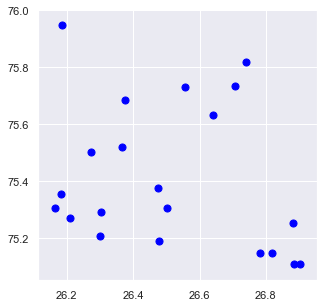

In [16]:
# ax = dfle.plot.scatter(x='lat', y='long', color='DarkGreen',s = 0);
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
scatter = ax.scatter(dfle['lat'],dfle['lng'],color='blue',s=50)

In [17]:
my_df = dfle.copy()
my_df = my_df.iloc[0:0]
my_df

,__v,_id,date,disease__id,disease_livestock__id,disease_livestock_breed,disease_livestock_population,disease_morbidity,disease_mortality,disease_name,...,healthCenter_web,lat,lng,patientAddress,patientContact,patientEmail,patientName,pincode,status,disease


In [18]:
centers = [0,0]
centers
print(type(centers))

<class 'list'>


## K-Means Clustering

In [19]:
for x in range(count):
    xdf = dfle.loc[dfle['disease'] == x]
#     print(xdf)
    dist_points_from_cluster_center = []
    q = xdf.shape[0]
    temp = xdf.loc[:,['lat','lng']]
    K = range(1,q)
    if(q>1):
        for no_of_clusters in K:
            k_model = KMeans(n_clusters = no_of_clusters)
            k_model.fit(temp)
            dist_points_from_cluster_center.append(k_model.inertia_)

        #Function to find distance between a point and a line
        def calc_distance(x1,y1,a,b,c):
            d=abs((a*x1 + b*y1 +c))/(math.sqrt(a*a + b*b))
            return d
        print(dist_points_from_cluster_center)
        a = dist_points_from_cluster_center[0] - dist_points_from_cluster_center[q-2]
        b = K[q-2] - K[0]
        c1 = K[0]*dist_points_from_cluster_center[q-2]
        c2 = K[q-2]*dist_points_from_cluster_center[0]
        c = c1-c2

        distance_of_points_from_line = []
        for k in range(q-1):
            distance_of_points_from_line.append(
            calc_distance(K[k], dist_points_from_cluster_center[k],a,b,c))

        optimum_k = distance_of_points_from_line.index(max(distance_of_points_from_line)) + 1
    else:
        optimum_k = 1
    kmeans = KMeans(n_clusters = optimum_k, init ='k-means++',random_state=50)

    kmeans.fit(temp)
    y = kmeans.fit_predict(temp)
    
    xdf = xdf.copy()
    xdf['cluster_label'] = (y + (x*10))/10
    
    center = kmeans.cluster_centers_
#     print(type(center))
    xdf['cluster_centre_lat'] = center[0,0]
    xdf['cluster_centre_lng'] = center[0,1]
#     xdf['center'] = center
#     print(centers)
#     print(center)
    centers = np.vstack((centers,center))
    xdf
    my_df = my_df.append(xdf,ignore_index=True,sort = False)

[0.6401692093068347, 0.21506594887275046, 0.05157172001766625, 0.01675212571950032, 0.0061972933504999845]
[1.2706200937910084, 0.6234009418133345, 0.2429624654825022, 0.08031859936916858, 0.03848391766750102, 0.018025538883499045, 0.008309492738499567]
[0.05137052573000084]
[0.1372826535959985, 0.004725814221000165]


C:\Users\Owner\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Labelled Dataframe

In [20]:
my_df.fillna(0,inplace=True)
my_df

,__v,_id,date,disease__id,disease_livestock__id,disease_livestock_breed,disease_livestock_population,disease_morbidity,disease_mortality,disease_name,...,patientAddress,patientContact,patientEmail,patientName,pincode,status,disease,cluster_label,cluster_centre_lat,cluster_centre_lng
0,0,5f22c90e3d219e35c441a100,8/6/2020,5f22c50ed5a95200248242e0,5f22c50ed5a95200248242e2,Buffalo,6000000,40,50,Azurskey's,...,"678/28, Krishan Kuteer, New Shringaar Chavri",919462904912,khyati.goyal32@gmail.com,Khyati Goyal,305001,infected,0,0.0,26.882633,75.179481
1,0,5f22c9e83d219e35c441a114,8/7/2020,5f22c50ed5a95200248242e0,5f22c50ed5a95200248242e2,Buffalo,6000000,40,50,Azurskey's,...,"OMAX City,Jaipur",919079265263,sharmahitesha7@gmail.com,Hitesha Sharma,321242,deceased,0,0.2,26.882633,75.179481
2,0,5f22d4d83d219e35c441a2be,8/6/2020,5f22c50ed5a95200248242e0,5f22c50ed5a95200248242e2,Buffalo,6000000,40,50,Azurskey's,...,"B-block, Malviya Nagar,Jaipur",919462904912,paridhi@gmail.com,Paridhi Vijay,305123,infected,0,0.1,26.882633,75.179481
3,0,5f22d9053d219e35c441a433,8/6/2020,5f22c50ed5a95200248242e0,5f22c50ed5a95200248242e2,Buffalo,6000000,40,50,Azurskey's,...,Sanganer Jaipur,919462904912,samkit@gmail.com,Samkit Jain,123456,infected,0,0.0,26.882633,75.179481
4,0,5f22d9d03d219e35c441a48e,8/6/2020,5f22c50ed5a95200248242e0,5f22c50ed5a95200248242e2,Buffalo,6000000,40,50,Azurskey's,...,"Sector 62, Noida",919462904912,kshish@gmail.com,Kshish Ashish,305128,recovered,0,0.2,26.882633,75.179481
5,0,5f22dfed3d219e35c441a7aa,8/6/2020,5f22c50ed5a95200248242e0,5f22c50ed5a95200248242e2,Buffalo,6000000,40,50,Azurskey's,...,"678/28, Krishan Kuteer, New Shringaar Chavri",919413228169,ranjan@gmail.com,Ranjan Goyal,305001,deceased,0,0.2,26.882633,75.179481
6,0,5f22c94b3d219e35c441a108,8/5/2020,5f22c5afd5a95200248242e4,5f22c5afd5a95200248242e8,Goat,10000000,60,40,Blackleg,...,"Phulera, Jaipur",919462904912,samiksha@gmail.com,Samiksha Jain,305121,infected,1,1.0,26.842139,75.127879
7,0,5f22ca393d219e35c441a120,8/5/2020,5f22c5afd5a95200248242e4,5f22c5afd5a95200248242e8,Goat,10000000,60,40,Blackleg,...,"Malviya Nagar, Jaipur",919462904912,kanishkajain@gmail.com,Kanishka Jain,305212,recovered,1,1.2,26.842139,75.127879
8,0,5f22ca8f3d219e35c441a130,8/6/2020,5f22c5afd5a95200248242e4,5f22c5afd5a95200248242e8,Goat,10000000,60,40,Blackleg,...,"B block, Malviya Nagar, Jaipur",919950856814,paridhivijay@gmail.com,Paridhi Vijay,32123,recovered,1,1.1,26.842139,75.127879
9,0,5f22d2ad3d219e35c441a26a,8/5/2020,5f22c5afd5a95200248242e4,5f22c5afd5a95200248242e8,Goat,10000000,60,40,Blackleg,...,"Vaishali Nagar,Jaipur",919829661751,rohan@gmail.com,Rohan Gupta,305012,infected,1,1.2,26.842139,75.127879


# Centers

In [21]:
# centers.remove([0,0])
centers = np.delete(centers, 0,0) 
centers

array([[26.8826335 , 75.1794815 ],
       [26.374576  , 75.686548  ],
       [26.329406  , 75.22184167],
       [26.842139  , 75.1278785 ],
       [26.31431   , 75.32391067],
       [26.49379933, 75.83216833],
       [26.817996  , 75.148166  ],
       [26.342262  , 75.330797  ],
       [26.639233  , 75.630442  ],
       [26.448658  , 75.585206  ]])

In [22]:
labels = my_df['cluster_label']
len(labels)

21

In [23]:
from collections import Counter, defaultdict
print(Counter(labels))

Counter({0.2: 3, 1.2: 3, 1.1: 3, 5.0: 3, 0.0: 2, 1.0: 2, 3.0: 2, 0.1: 1, 2.0: 1, 4.0: 1})


# Visualising Points

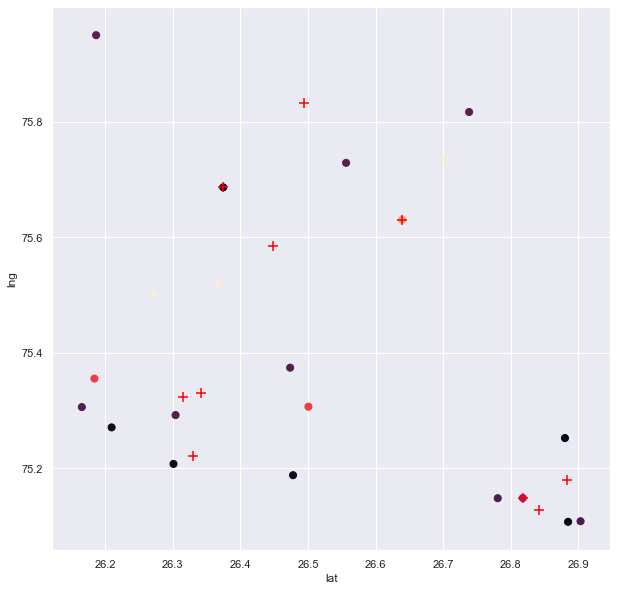

In [24]:
# plt.style.use(['dark_background'])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(my_df['lat'],my_df['lng'],c=labels,s=50)
for i,j in centers:
    ax.scatter(i,j,s=100,c='red',marker='+')
ax.set_xlabel('lat')
ax.set_ylabel('lng')
# plt.colorbar(scatter)

plt.show()

In [25]:
import json

data = centers
list = [{"latitude": x[0], "longitude": x[1]} for x in data]

output = json.dumps(list)

In [26]:
output

'[{"latitude": 26.882633499999997, "longitude": 75.1794815}, {"latitude": 26.374576, "longitude": 75.686548}, {"latitude": 26.329406, "longitude": 75.22184166666666}, {"latitude": 26.842139, "longitude": 75.12787850000001}, {"latitude": 26.31431, "longitude": 75.32391066666666}, {"latitude": 26.49379933333333, "longitude": 75.83216833333334}, {"latitude": 26.817996, "longitude": 75.148166}, {"latitude": 26.342261999999998, "longitude": 75.33079699999999}, {"latitude": 26.639233, "longitude": 75.630442}, {"latitude": 26.448658000000002, "longitude": 75.585206}]'

In [27]:
with open('result.json', 'w') as outfile:
    json.dump(output, outfile,indent = 4)

In [30]:
import json
for i in range(my_df.shape[0]):
    ini_string={
        
        "disease": {
            "_id": my_df["disease__id"][i],
            "livestock": [
                {
                    "_id": my_df["disease_livestock__id"][i],
                    "breed": my_df["disease_livestock_breed"][i],
                    "population": my_df["disease_livestock_population"][i]
                }
            ],
            "vaccine": [
                {
                    "_id": my_df["disease_vaccine__id"][i],
                    "name": my_df["disease_vaccine_name"][i],
                    "scientificName": my_df["disease_vaccine_scientificName"][i],
                    "duration": my_df["disease_vaccine_duration"][i],
                    "forHuman": my_df["disease_vaccine_forHuman"][i]
                }
            ],
            "name": my_df["disease_name"][i],
            "scientificName": my_df["disease_scientificName"][i],
            "precautions" : my_df["disease_precautions"][i],
            "symptoms": my_df["disease_symptoms"][i],
            "morbidity": my_df["disease_morbidity"][i],
            "mortality": my_df["disease_mortality"][i],
            "total_affected": my_df["disease_total_affected"][i],
            "total_deaths": my_df["disease_total_deaths"][i]
        },
        "healthCenter": {
            "_id": my_df["healthCenter__id"][i],
            "address": my_df["healthCenter_address"][i],
            "email": my_df["healthCenter_email"][i],
            "contact": my_df["healthCenter_contact"][i],
            "name": my_df["healthCenter_contact"][i],
            "incharge": my_df["healthCenter_incharge"][i],
            "pincode": my_df["healthCenter_pincode"][i],
            "web": my_df["healthCenter_web"][i],
            "total_recovered":my_df["healthCenter_total_recovered"][i],
            "total_affected": my_df["healthCenter_total_affected"][i],
            "total_deaths": my_df["healthCenter_total_deaths"][i]
            
        },
        "total_recovered":my_df["disease_total_recovered"][i],
        "total_affected": my_df["disease_total_affected"][i],
        "total_deaths": my_df["disease_total_deaths"][i],
        "__v": my_df["__v"][i],
        "radius" :my_df["disease"][i],
        "lat": my_df["cluster_centre_lat"][i],
        "lng": my_df["cluster_centre_lng"][i]
    }

    def convert(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()

    y=json.dumps(ini_string, default=convert)
    headers = {'Accept' : 'application/json', 'Content-Type' : 'application/json'}
    url="https://diseasex-backend.herokuapp.com/outbreaks"
    r = requests.post(url, data=y,headers=headers)    

200
500
500
500
500
500
200
500
500
500
500
500
500
500
200
200
500
200
200
500
500


In [32]:
print("Clustering Successful !")
print("Data upload to database Successful !")

Clustering Successful !
Data upload to database Successful !
